In [ ]:
from google.colab import drive
drive.mount('/content/drive')

Drive already mounted at /content/drive; to attempt to forcibly remount, call drive.mount("/content/drive", force_remount=True).


In [ ]:
!cp /content/drive/MyDrive/DoAnCV/eff_dataset.zip /content/dataset.zip

In [ ]:
!unzip '/content/dataset.zip' -d '/content/dataset'

Streaming output truncated to the last 5000 lines.
  inflating: /content/dataset/eff_dataset/train/class_8/149564_bbox0.jpg  
  inflating: /content/dataset/eff_dataset/train/class_8/149629_bbox0.jpg  
  inflating: /content/dataset/eff_dataset/train/class_8/149781_bbox0.jpg  
  inflating: /content/dataset/eff_dataset/train/class_8/149782_bbox0.jpg  
  inflating: /content/dataset/eff_dataset/train/class_8/149786_bbox0.jpg  
  inflating: /content/dataset/eff_dataset/train/class_8/149913_bbox0.jpg  
  inflating: /content/dataset/eff_dataset/train/class_8/149916_bbox0.jpg  
  inflating: /content/dataset/eff_dataset/train/class_8/149917_bbox0.jpg  
  inflating: /content/dataset/eff_dataset/train/class_8/149919_bbox0.jpg  
  inflating: /content/dataset/eff_dataset/train/class_8/149920_bbox0.jpg  
  inflating: /content/dataset/eff_dataset/train/class_8/149922_bbox0.jpg  
  inflating: /content/dataset/eff_dataset/train/class_8/149923_bbox0.jpg  
  inflating: /content/dataset/eff_dataset/train/c

In [ ]:
import torch
import torch.nn as nn
import torch.optim as optim
from torch.utils.data import DataLoader, Dataset, random_split
import torchvision
from torchvision import transforms, models
import os
from PIL import Image
import numpy as np
from tqdm import tqdm

In [ ]:
NUM_CLASSES = 13
IMG_SIZE = 224
BATCH_SIZE = 128
NUM_EPOCHS = 10
VAL_SPLIT = 0.2
DEVICE = torch.device("cuda" if torch.cuda.is_available() else "cpu")

In [ ]:
train_transforms = transforms.Compose([
    transforms.Resize((IMG_SIZE, IMG_SIZE)),
    transforms.RandomHorizontalFlip(),
    transforms.RandomRotation(10),
    transforms.ToTensor(),
    transforms.Normalize(mean=[0.485, 0.456, 0.406], std=[0.229, 0.224, 0.225])
])

val_transforms = transforms.Compose([
    transforms.Resize((IMG_SIZE, IMG_SIZE)),
    transforms.ToTensor(),
    transforms.Normalize(mean=[0.485, 0.456, 0.406], std=[0.229, 0.224, 0.225])
])

In [ ]:
class CustomImageDataset(Dataset):
    def __init__(self, root_dir, transform=None):
        self.root_dir = root_dir
        self.transform = transform
        self.classes = sorted(os.listdir(root_dir))
        self.class_to_idx = {cls_name: i for i, cls_name in enumerate(self.classes)}
        self.images = []

        for cls_name in self.classes:
            class_path = os.path.join(root_dir, cls_name)
            for img_name in os.listdir(class_path):
                if img_name.endswith(('.png', '.jpg', '.jpeg')):
                    self.images.append((os.path.join(class_path, img_name), cls_name))

    def __len__(self):
        return len(self.images)

    def __getitem__(self, idx):
        img_path, class_name = self.images[idx]
        image = Image.open(img_path).convert('RGB')
        label = self.class_to_idx[class_name]

        if self.transform:
            image = self.transform(image)

        return image, label

In [ ]:
def create_dataloaders(data_dir):
    dataset = CustomImageDataset(data_dir, transform=train_transforms)

    # Chia train/val
    total_size = len(dataset)
    val_size = int(VAL_SPLIT * total_size)
    train_size = total_size - val_size
    train_dataset, val_dataset = random_split(dataset, [train_size, val_size])

    val_dataset.dataset.transform = val_transforms

    train_loader = DataLoader(train_dataset, batch_size=BATCH_SIZE, shuffle=True, num_workers=4)
    val_loader = DataLoader(val_dataset, batch_size=BATCH_SIZE, shuffle=False, num_workers=4)

    return train_loader, val_loader

In [ ]:
def train_model(model, train_loader, val_loader, criterion, optimizer, num_epochs):
    best_acc = 0.0
    best_model_path = "best_model.pth"

    for epoch in range(num_epochs):
        model.train()
        running_loss = 0.0
        correct = 0
        total = 0

        for images, labels in tqdm(train_loader):
            images, labels = images.to(DEVICE), labels.to(DEVICE)

            optimizer.zero_grad()
            outputs = model(images)
            loss = criterion(outputs, labels)
            loss.backward()
            optimizer.step()

            running_loss += loss.item()
            _, predicted = torch.max(outputs.data, 1)
            total += labels.size(0)
            correct += (predicted == labels).sum().item()

        train_loss = running_loss / len(train_loader)
        train_acc = 100 * correct / total

        model.eval()
        val_loss = 0.0
        correct = 0
        total = 0

        with torch.no_grad():
            for images, labels in val_loader:
                images, labels = images.to(DEVICE), labels.to(DEVICE)
                outputs = model(images)
                loss = criterion(outputs, labels)
                val_loss += loss.item()
                _, predicted = torch.max(outputs.data, 1)
                total += labels.size(0)
                correct += (predicted == labels).sum().item()

        val_loss = val_loss / len(val_loader)
        val_acc = 100 * correct / total

        print(f'Epoch [{epoch+1}/{num_epochs}], '
              f'Train Loss: {train_loss:.4f}, Train Acc: {train_acc:.2f}%, '
              f'Val Loss: {val_loss:.4f}, Val Acc: {val_acc:.2f}%')

        if val_acc > best_acc:
            best_acc = val_acc
            torch.save(model.state_dict(), best_model_path)
            print(f"Saved best model with accuracy: {best_acc:.2f}%")

    return model

In [ ]:
def main():
    data_dir = "/content/dataset/eff_dataset/train"

    # DataLoader
    train_loader, val_loader = create_dataloaders(data_dir)

    model = models.resnet50(pretrained=True)
    num_ftrs = model.fc.in_features
    model.fc = nn.Linear(num_ftrs, NUM_CLASSES)
    model = model.to(DEVICE)

    criterion = nn.CrossEntropyLoss()
    optimizer = optim.Adam(model.parameters(), lr=0.001)

    model = train_model(model, train_loader, val_loader, criterion, optimizer, NUM_EPOCHS)

    torch.save(model.state_dict(), "final_model.pth")
    print("Training completed and final model saved.")

if __name__ == "__main__":
    main()

/usr/local/lib/python3.11/dist-packages/torchvision/models/_utils.py:208: UserWarning: The parameter 'pretrained' is deprecated since 0.13 and may be removed in the future, please use 'weights' instead.
  warnings.warn(
/usr/local/lib/python3.11/dist-packages/torchvision/models/_utils.py:223: UserWarning: Arguments other than a weight enum or `None` for 'weights' are deprecated since 0.13 and may be removed in the future. The current behavior is equivalent to passing `weights=ResNet50_Weights.IMAGENET1K_V1`. You can also use `weights=ResNet50_Weights.DEFAULT` to get the most up-to-date weights.
  warnings.warn(msg)
100%|██████████| 408/408 [09:44<00:00,  1.43s/it]


Epoch [1/10], Train Loss: 1.0056, Train Acc: 65.82%, Val Loss: 0.9468, Val Acc: 68.13%
Saved best model with accuracy: 68.13%


100%|██████████| 408/408 [09:43<00:00,  1.43s/it]


Epoch [2/10], Train Loss: 0.7531, Train Acc: 74.13%, Val Loss: 0.8069, Val Acc: 71.55%
Saved best model with accuracy: 71.55%


100%|██████████| 408/408 [09:41<00:00,  1.43s/it]


Epoch [3/10], Train Loss: 0.6370, Train Acc: 77.78%, Val Loss: 0.7529, Val Acc: 74.04%
Saved best model with accuracy: 74.04%


100%|██████████| 408/408 [09:40<00:00,  1.42s/it]


Epoch [4/10], Train Loss: 0.5568, Train Acc: 80.59%, Val Loss: 0.7333, Val Acc: 75.49%
Saved best model with accuracy: 75.49%


100%|██████████| 408/408 [09:41<00:00,  1.42s/it]


Epoch [5/10], Train Loss: 0.4755, Train Acc: 83.42%, Val Loss: 0.7824, Val Acc: 74.17%


100%|██████████| 408/408 [09:39<00:00,  1.42s/it]


Epoch [6/10], Train Loss: 0.4058, Train Acc: 85.67%, Val Loss: 0.8223, Val Acc: 73.91%


100%|██████████| 408/408 [09:38<00:00,  1.42s/it]


Epoch [7/10], Train Loss: 0.3401, Train Acc: 87.81%, Val Loss: 0.7222, Val Acc: 77.29%
Saved best model with accuracy: 77.29%


100%|██████████| 408/408 [09:38<00:00,  1.42s/it]


Epoch [8/10], Train Loss: 0.2749, Train Acc: 90.35%, Val Loss: 0.8017, Val Acc: 76.31%


100%|██████████| 408/408 [09:38<00:00,  1.42s/it]


Epoch [9/10], Train Loss: 0.2294, Train Acc: 91.79%, Val Loss: 0.8743, Val Acc: 75.99%


100%|██████████| 408/408 [09:38<00:00,  1.42s/it]


Epoch [10/10], Train Loss: 0.1903, Train Acc: 93.20%, Val Loss: 1.0503, Val Acc: 74.46%
Training completed and final model saved.


['class_0', 'class_1', 'class_10', 'class_11', 'class_12', 'class_2', 'class_3', 'class_4', 'class_5', 'class_6', 'class_7', 'class_8', 'class_9']


/usr/local/lib/python3.11/dist-packages/torchvision/models/_utils.py:208: UserWarning: The parameter 'pretrained' is deprecated since 0.13 and may be removed in the future, please use 'weights' instead.
  warnings.warn(
/usr/local/lib/python3.11/dist-packages/torchvision/models/_utils.py:223: UserWarning: Arguments other than a weight enum or `None` for 'weights' are deprecated since 0.13 and may be removed in the future. The current behavior is equivalent to passing `weights=None`.
  warnings.warn(msg)


Nhập URL ảnh hoặc đường dẫn file/thư mục (nhập 'exit' để thoát):
> https://i.postimg.cc/HnnMYBnY/photo-2025-06-04-14-59-39.jpg


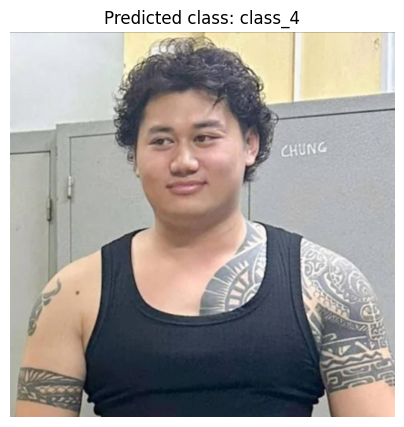

URL: https://i.postimg.cc/HnnMYBnY/photo-2025-06-04-14-59-39.jpg -> Predicted class: class_4


KeyboardInterrupt: Interrupted by user

In [ ]:
import torch
import torch.nn as nn
import torchvision
from torchvision import transforms, models
from PIL import Image
import requests
from io import BytesIO
import os
import matplotlib.pyplot as plt
import numpy as np

NUM_CLASSES = 13
IMG_SIZE = 224
DEVICE = torch.device("cuda" if torch.cuda.is_available() else "cpu")

test_transforms = transforms.Compose([
    transforms.Resize((IMG_SIZE, IMG_SIZE)),
    transforms.ToTensor(),
    transforms.Normalize(mean=[0.485, 0.456, 0.406], std=[0.229, 0.224, 0.225])
])

def load_model(model_path):
    model = models.resnet50(pretrained=False)
    num_ftrs = model.fc.in_features
    model.fc = nn.Linear(num_ftrs, NUM_CLASSES)
    model.load_state_dict(torch.load(model_path, map_location=DEVICE))
    model = model.to(DEVICE)
    model.eval()
    return model

def predict_image(model, image, class_names):
    image = test_transforms(image)
    image = image.unsqueeze(0)
    image = image.to(DEVICE)

    with torch.no_grad():
        outputs = model(image)
        _, predicted = torch.max(outputs, 1)
        predicted_class = class_names[predicted.item()]

    return predicted_class

def predict_image_from_url(model, url, class_names):
    try:
        response = requests.get(url)
        response.raise_for_status()
        image = Image.open(BytesIO(response.content)).convert('RGB')

        predicted_class = predict_image(model, image, class_names)

        plt.figure(figsize=(5, 5))
        plt.imshow(image)
        plt.axis('off')
        plt.title(f"Predicted class: {predicted_class}")
        plt.show()

        return predicted_class
    except Exception as e:
        return f"Error loading image from URL: {str(e)}"

def predict_image_from_file(model, image_path, class_names):
    try:
        image = Image.open(image_path).convert('RGB')
        predicted_class = predict_image(model, image, class_names)

        plt.figure(figsize=(5, 5))
        plt.imshow(image)
        plt.axis('off')
        plt.title(f"Predicted class: {predicted_class}")
        plt.show()

        return predicted_class
    except Exception as e:
        return f"Error loading image from file: {str(e)}"

def predict_folder(model, folder_path, class_names):
    predictions = []
    for img_name in os.listdir(folder_path):
        if img_name.endswith(('.png', '.jpg', '.jpeg')):
            img_path = os.path.join(folder_path, img_name)
            predicted_class = predict_image_from_file(model, img_path, class_names)
            predictions.append((img_name, predicted_class))
    return predictions

def main():
    model_path = "/content/drive/MyDrive/DoAnCV/best_cnn_resnet50.pth"

    class_names = None
    train_dir = "/content/dataset/eff_dataset/train"
    if os.path.exists(train_dir):
        class_names = sorted(os.listdir(train_dir))
    else:
        class_names = [f"class{i}" for i in range(1, NUM_CLASSES + 1)]
        print("Warning: train directory not found. Using default class names:", class_names)
    print(class_names)
    model = load_model(model_path)

    print("Nhập URL ảnh hoặc đường dẫn file/thư mục (nhập 'exit' để thoát):")
    while True:
        user_input = input("> ").strip()
        if user_input.lower() == 'exit':
            break

        if user_input.startswith(('http://', 'https://')):
            predicted_class = predict_image_from_url(model, user_input, class_names)
            print(f"URL: {user_input} -> Predicted class: {predicted_class}")
        elif os.path.isfile(user_input):
            predicted_class = predict_image_from_file(model, user_input, class_names)
            print(f"Image: {user_input} -> Predicted class: {predicted_class}")
        elif os.path.isdir(user_input):
            predictions = predict_folder(model, user_input, class_names)
            for img_name, predicted_class in predictions:
                print(f"Image: {img_name} -> Predicted class: {predicted_class}")
        else:
            print("Error: Input must be a valid image file, folder path, or URL.")

if __name__ == "__main__":
    main()

In [ ]:
!cp /content/best_model.pth /content/drive/MyDrive/DoAnCV/best_cnn_resnet50.pth

In [ ]:
!cp /content/final_model.pth /content/drive/MyDrive/DoAnCV/final_cnn_resnet50.pth